In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler


# **1. DATA PREPARATION**

In [27]:
# Import database
df = pd.read_csv('database.smi',delim_whitespace=True,header=None)
df.columns = ['SMILE','Name','number']

# Modify the ID columns
df['number'] = df['number'].astype(str)
df['ID'] = df['Name'] + df['number']
df = df.drop(['Name','number'],axis=1)
df['MOL'] = df['SMILE'].apply(lambda i: Chem.MolFromSmiles(i))

In [46]:
# Create column for target value, the name that begins with "X" is the active one.
df['Activity'] = 0
df.loc[df['ID'].str.startswith('X'), 'Activity'] = 1

# Extract physiochemical descriptors
df['MolLogP'] = df['MOL'].apply(lambda i: Descriptors.MolLogP(i))
df['MolWt'] = df['MOL'].apply(lambda i: Descriptors.MolWt(i))
df['HBD'] =  df['MOL'].apply(lambda i: Descriptors.NumHDonors(i))
df['HBA'] =  df['MOL'].apply(lambda i: Descriptors.NumHAcceptors(i))
df['NumAromaticRings'] =  df['MOL'].apply(lambda i: Descriptors.NumAromaticRings(i))
df['NumRotatableBonds'] =  df['MOL'].apply(lambda i: Descriptors.NumRotatableBonds(i))
df['TPSA'] =  df['MOL'].apply(lambda i: Descriptors.TPSA(i))
df['MolMR'] =  df['MOL'].apply(lambda i: Descriptors.MolMR(i))
df['BertzCT'] = df['MOL'].apply(lambda i: Descriptors.BertzCT(i))
df['BalabanJ'] = df['MOL'].apply(lambda i: Descriptors.BalabanJ(i))
df['FpDensityMorgan1'] = df['MOL'].apply(lambda i: Descriptors.FpDensityMorgan1(i))
df['FpDensityMorgan2'] = df['MOL'].apply(lambda i: Descriptors.FpDensityMorgan2(i))
df['FpDensityMorgan3'] = df['MOL'].apply(lambda i: Descriptors.FpDensityMorgan3(i))
df['FractionCSP3'] = df['MOL'].apply(lambda i: Descriptors.FractionCSP3(i))
df['HeavyAtomCount'] = df['MOL'].apply(lambda i: Descriptors.HeavyAtomCount(i))
df['HeavyAtomWt'] = df['MOL'].apply(lambda i: Descriptors.HeavyAtomMolWt(i))
df['RingCount'] = df['MOL'].apply(lambda i: Descriptors.RingCount(i))

# Standardize numerical data
df_num = df.select_dtypes('number').drop(['Activity'],axis=1) # Extract numerical columns

scaler = StandardScaler()
df_num_standard = scaler.fit_transform(df_num)
df_num_standard = pd.DataFrame(df_num_standard, columns= df_num.columns)

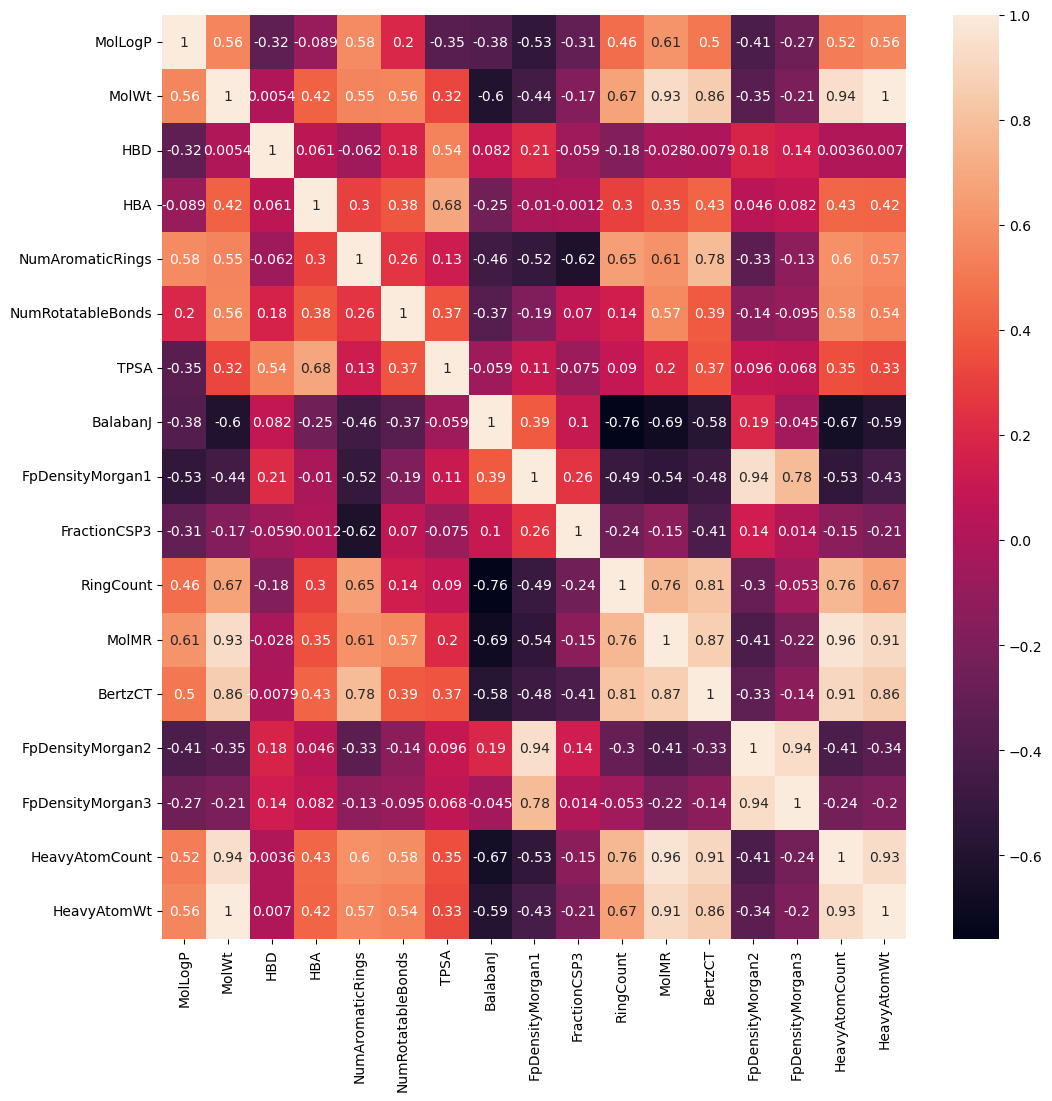

In [48]:
# Check the collinearity between features
correlation_matrix = df_num_standard.corr()
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(correlation_matrix,annot=True, ax=ax)
plt.show()

In [51]:
# Filter out features that share the high correlation.
threshold = 0.8
correlated_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.append(colname)

df_num_standard = df_num_standard.drop(correlated_features, axis = 1)

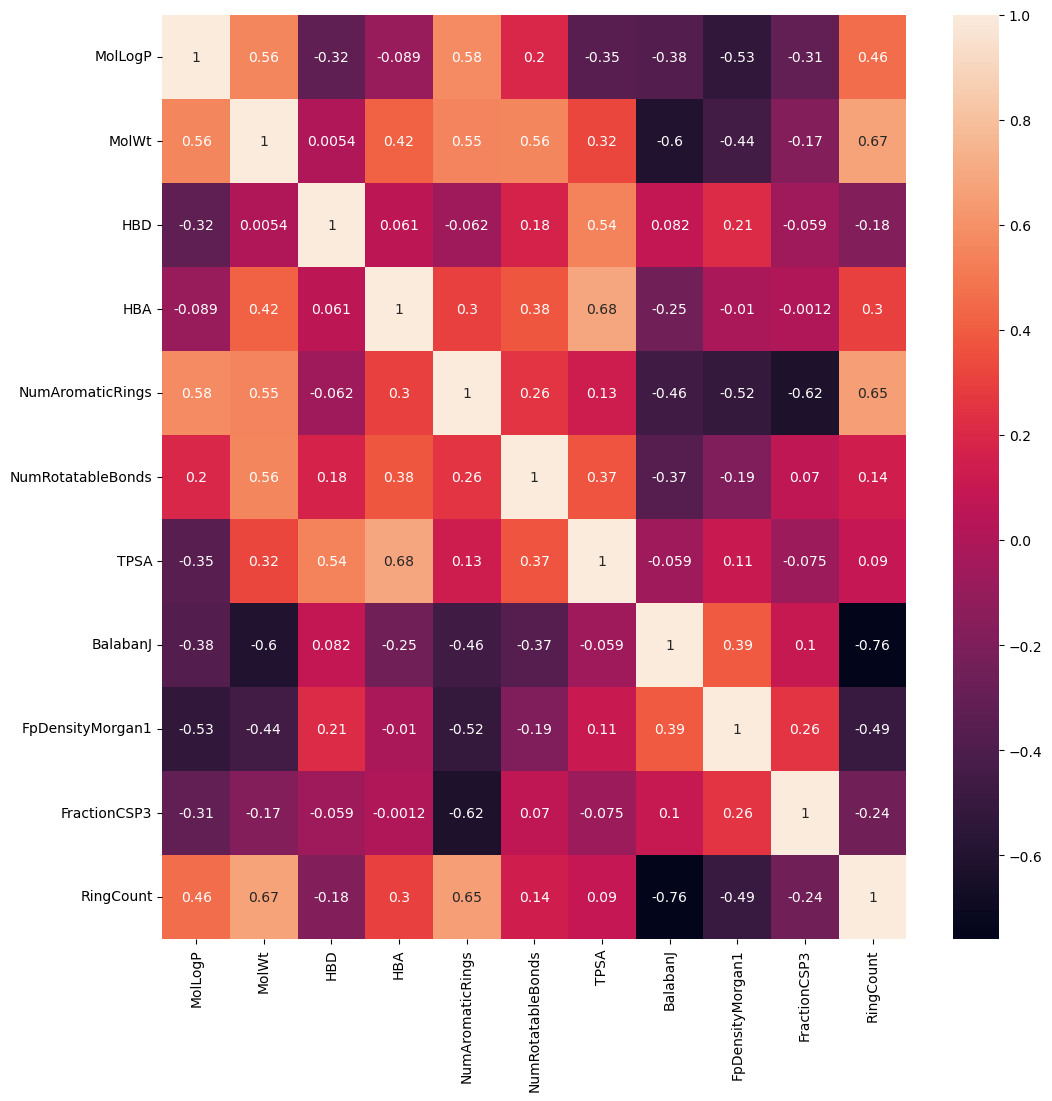

In [53]:
# Recheck collinearity
correlation_matrix = df_num_standard.corr()
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(correlation_matrix,annot=True, ax=ax)
plt.show()

In [30]:
# Get Morgan fingerprint
morgan_fp = [AllChem.GetMorganFingerprintAsBitVect(i, radius = 2, nBits=2048) for i in df['MOL']]
morgan_fp_array = np.asarray(morgan_fp)
morgan_df = pd.DataFrame(morgan_fp_array)

# Combine physicochemical descriptors and Morgan fingerprint
df_combine = pd.concat([df_num_standard,morgan_df], axis=1)

# Turn column names into strings
df_combine.columns = df_combine.columns.astype(str)

# **2. RANDOM FOREST MODEL FOR PHYSIOCHEMICAL FEATURES**

In [72]:
# Split data
x = df_num_standard
y = df['Activity']

# Data imbalance handle
sampling_imbalance = RandomOverSampler(random_state=42)

# Splite train test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=342)
x_train_resampled, y_train_resampled = sampling_imbalance.fit_resample(x_train,y_train)
x_test_resampled, y_test_resampled = sampling_imbalance.fit_resample(x_test,y_test)

In [60]:
# Define the model
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)

# Build the model
rf_model.fit(x_train_resampled, y_train_resampled)

# Evaluate on test set
prediction = rf_model.predict(x_test_resampled)



cf_matrix = pd.DataFrame(confusion_matrix(y_test_resampled,prediction), columns = ['Predict 0','Predict 1'], index=['Actual 0','Actual 1'])
print('Evaluation of physiochemical model')
print(classification_report(y_test_resampled, prediction))
print(cf_matrix)


Evaluation of physiochemical model
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1959
           1       1.00      0.96      0.98      1959

    accuracy                           0.98      3918
   macro avg       0.98      0.98      0.98      3918
weighted avg       0.98      0.98      0.98      3918

          Predict 0  Predict 1
Actual 0       1959          0
Actual 1         86       1873


# **3. RANDOM FOREST MODEL FOR FINGERPRINT FEATURES**

In [57]:
# Split data
x = morgan_df
y = df['Activity']

# Data imbalance handle
sampling_imbalance = RandomOverSampler(random_state=42)

# Splite train test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=342)
x_train_resampled, y_train_resampled = sampling_imbalance.fit_resample(x_train,y_train)
x_test_resampled, y_test_resampled = sampling_imbalance.fit_resample(x_test,y_test)

In [62]:
# Define the model
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)

# Build the model
rf_model.fit(x_train_resampled, y_train_resampled)

# Evaluate on test set
prediction = rf_model.predict(x_test_resampled)
cf_matrix = pd.DataFrame(confusion_matrix(y_test_resampled,prediction), columns = ['Predict 0','Predict 1'], index=['Actual 0','Actual 1'])

print('Evaluation of fingerprint model')
print(classification_report(y_test_resampled, prediction))
print(cf_matrix)


Evaluation of fingerprint model
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1959
           1       1.00      0.96      0.98      1959

    accuracy                           0.98      3918
   macro avg       0.98      0.98      0.98      3918
weighted avg       0.98      0.98      0.98      3918

          Predict 0  Predict 1
Actual 0       1959          0
Actual 1         86       1873


# **3. RANDOM FOREST MODEL FOR COMBINE FEATURES**

In [98]:
# Split data
x = df_combine
y = df['Activity']

# Data imbalance handle
sampling_imbalance = RandomOverSampler(random_state=42)

# Splite train test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=342)
x_train_resampled, y_train_resampled = sampling_imbalance.fit_resample(x_train,y_train)
x_test_resampled, y_test_resampled = sampling_imbalance.fit_resample(x_test,y_test)

In [66]:
# Define the model
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)

# Build the model
rf_model.fit(x_train_resampled, y_train_resampled)

# Evaluate on test set
prediction = rf_model.predict(x_test_resampled)
cf_matrix = pd.DataFrame(confusion_matrix(y_test_resampled,prediction), columns = ['Predict 0','Predict 1'], index=['Actual 0','Actual 1'])

print('Evaluation of combined model')
print(classification_report(y_test_resampled, prediction))
print(cf_matrix)


Evaluation of combined model
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1959
           1       1.00      0.98      0.99      1959

    accuracy                           0.99      3918
   macro avg       0.99      0.99      0.99      3918
weighted avg       0.99      0.99      0.99      3918

          Predict 0  Predict 1
Actual 0       1959          0
Actual 1         41       1918
